In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [2]:
import pandas as pd
df = pd.read_csv(f"{path}/creditcard.csv")

In [3]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


### Большой дисбаланс классов

# Контекст
### Создадим sampled_df, будем его использовать для добавления в базу данных и дальнейшего инференса

In [4]:
class1_samples = df[df['Class'] == 1].sample(n=50, random_state=42)
class0_samples = df[df['Class'] != 1].sample(n=5000, random_state=42)

sampled_df = pd.concat([class1_samples, class0_samples]).reset_index(drop=True)

df = df.drop(sampled_df.index).reset_index(drop=True)

### Будем использовать SMOTE OverSampling для балансировки классов

In [5]:
pip install xgboost lightgbm catboost optuna imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 27.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 7.8 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 30.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 34.0 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [7]:
X = df.drop('Class', axis=1)
y = df['Class']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

import optuna
from optuna.samplers import TPESampler
# from optuna.integration import RichLoggingCallback

In [11]:
def create_objective(model_name, model):
    def objective(trial):
        k_neighbors = trial.suggest_int("smote_k_neighbors", 2, 20)

        if model_name == "XGBoost":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
                'max_depth': trial.suggest_int('max_depth', 2, 15),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            }
            clf = XGBClassifier(**params, random_state=42, n_jobs=-1, eval_metric='logloss')


        elif model_name == "CatBoost":
            params = {
                'iterations': trial.suggest_int('iterations', 200, 2000),
                'depth': trial.suggest_int('depth', 2, 15),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                'border_count': trial.suggest_int('border_count', 32, 255),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
            }
            clf = CatBoostClassifier(**params, random_state=42, verbose=False, thread_count=-1)

        pipeline = ImbPipeline([
            ('smote', SMOTE(k_neighbors=k_neighbors, random_state=42)),
            ('classifier', clf)
        ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
        
        return scores.mean() 

    return objective

In [22]:
base_models = {
    "XGBoost":      XGBClassifier(),
    "CatBoost":     CatBoostClassifier(),
}

results = {}
trained_pipelines = {}

In [23]:
for name, base_model in base_models.items():
    print(f"{name}")
    
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    study.optimize(create_objective(name, base_model), 
                   n_trials=10, 
                   n_jobs=-1, 
                   show_progress_bar=True, 
                   )

    best_params = study.best_params
    print(f"Лучший PR_AUC на CV для {name}: {study.best_value:.4f}")
    print(f"Лучшие параметры: {best_params}")

    smote_k = best_params.pop('smote_k_neighbors') 

    if name == "XGBoost":
        final_clf = XGBClassifier(**best_params, random_state=42, n_jobs=-1, eval_metric='logloss')
    elif name == "CatBoost":
        final_clf = CatBoostClassifier(**best_params, random_state=42, verbose=False, thread_count=-1)


    final_pipeline = ImbPipeline([
        ('smote', SMOTE(k_neighbors=smote_k, random_state=42)),
        ('classifier', final_clf)
    ])

    final_pipeline.fit(X_train, y_train)
    trained_pipelines[name]=final_pipeline
    
    y_pred = final_pipeline.predict(X_test)
    y_proba = final_pipeline.predict_proba(X_test)[:, 1]

    results[name] = {
        'CV_PR_AUC': study.best_value,
        'Test_Accuracy': accuracy_score(y_test, y_pred),
        'Test_F1': f1_score(y_test, y_pred),
        'Test_PR_AUC': average_precision_score(y_test, y_proba),
    }
    

[I 2025-12-15 01:15:39,152] A new study created in memory with name: no-name-5db89bd2-4dc9-4f66-8a0b-95329e0502c5


XGBoost


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-15 01:15:48,705] Trial 0 finished with value: 0.8493855461626523 and parameters: {'smote_k_neighbors': 15, 'n_estimators': 234, 'max_depth': 9, 'learning_rate': 0.28822334198062205, 'subsample': 0.876950592741027, 'colsample_bytree': 0.7879654197866972, 'reg_alpha': 2.783378991879903, 'reg_lambda': 0.7410431277100071}. Best is trial 0 with value: 0.8493855461626523.
[I 2025-12-15 01:15:53,908] Trial 1 finished with value: 0.8528532235882579 and parameters: {'smote_k_neighbors': 6, 'n_estimators': 364, 'max_depth': 6, 'learning_rate': 0.13203235329696117, 'subsample': 0.6699070886107213, 'colsample_bytree': 0.9198499076755497, 'reg_alpha': 3.4567773043708856, 'reg_lambda': 3.9171688327412606}. Best is trial 1 with value: 0.8528532235882579.
[I 2025-12-15 01:15:54,836] Trial 3 finished with value: 0.7907092123174131 and parameters: {'smote_k_neighbors': 9, 'n_estimators': 381, 'max_depth': 6, 'learning_rate': 0.013086643477275535, 'subsample': 0.8371038633827061, 'colsample_by

[I 2025-12-15 01:16:52,561] A new study created in memory with name: no-name-d98bbfc6-cb68-4ca4-962d-411ece21f1ad


CatBoost


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-15 01:18:53,670] Trial 7 finished with value: 0.7945487771523331 and parameters: {'smote_k_neighbors': 6, 'iterations': 256, 'depth': 3, 'learning_rate': 0.24063225313388856, 'l2_leaf_reg': 5.480756879484224, 'border_count': 190, 'bagging_temperature': 0.6509327436519332, 'random_strength': 2.9723319389767413}. Best is trial 7 with value: 0.7945487771523331.
[I 2025-12-15 01:21:41,424] Trial 5 finished with value: 0.8555922365702373 and parameters: {'smote_k_neighbors': 13, 'iterations': 382, 'depth': 8, 'learning_rate': 0.07632804299749528, 'l2_leaf_reg': 2.2221334436496902, 'border_count': 102, 'bagging_temperature': 0.957747280980482, 'random_strength': 9.061895475494232}. Best is trial 5 with value: 0.8555922365702373.
[I 2025-12-15 01:27:21,832] Trial 2 finished with value: 0.8330635996444946 and parameters: {'smote_k_neighbors': 14, 'iterations': 1618, 'depth': 5, 'learning_rate': 0.19811460129946282, 'l2_leaf_reg': 4.315084419770965, 'border_count': 141, 'bagging_temp

In [24]:
df_results = pd.DataFrame(results).T
df_results = df_results.round(4)
print(df_results.sort_values('Test_PR_AUC', ascending=False))

          CV_PR_AUC  Test_Accuracy  Test_F1  Test_PR_AUC
XGBoost      0.8552         0.9993   0.8141       0.8434
CatBoost     0.8600         0.9994   0.8182       0.8394


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
def conf_matrix(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {name}')
    plt.show()

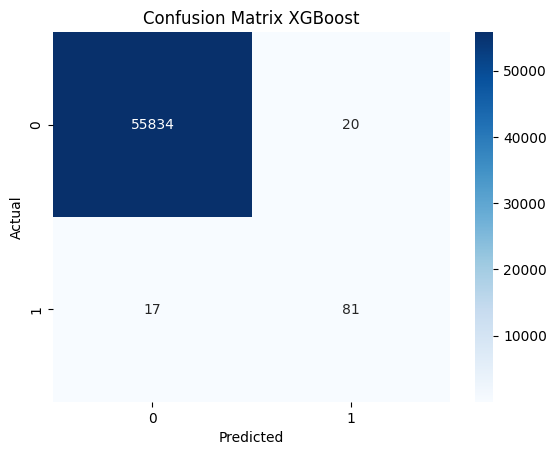

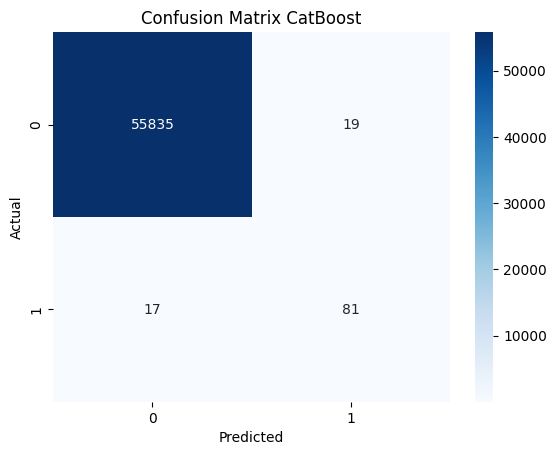

In [26]:
Ыfor name, trained_model in trained_pipelines.items():
    y_pred = trained_model.predict(X_test)
    conf_matrix(y_test, y_pred, name)

In [28]:
import joblib
joblib.dump(trained_pipelines["XGBoost"], 'xgb_final.joblib', compress=3)

['xgb_final.joblib']

In [29]:
df.to_csv('train_data.csv', index=False, encoding='utf-8')
sampled_df.to_csv('new_data.csv', index=False, encoding='utf-8')